In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
n_residual_blocks = 5

# The data, split between train and test sets
def data_split(digit):
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    if digit != 'all':
        if digit not in list(range(10)):
            print("choose correct digit value [0-9] or 'all'")
            return
        x_train=x_train[np.isin(y_train,[digit])]
        x_test=x_test[np.isin(y_test,[digit])]

    x_train = np.where(x_train < (0.33 * 256), 0, 1)
    x_train = x_train.astype(np.float32)
    
    x_test = np.where(x_test < (0.33 * 256), 0, 1)
    x_test = x_test.astype(np.float32)        
    return x_train, x_test

In [3]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [4]:
d = 5
data_train, data_test = data_split(d)
current_epoch = 0

In [5]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 28, 28, 128)      6400      
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 28, 28, 128)      98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                       

In [6]:
epoch = 1
pixel_cnn.fit(
    data_train, data_train, validation_data=(data_test, data_test), batch_size=128, epochs=epoch, verbose=2
)
current_epoch += epoch

43/43 - 19s - loss: 0.3234 - val_loss: 0.1292 - 19s/epoch - 444ms/step


100%|██████████| 28/28 [00:58<00:00,  2.08s/it]


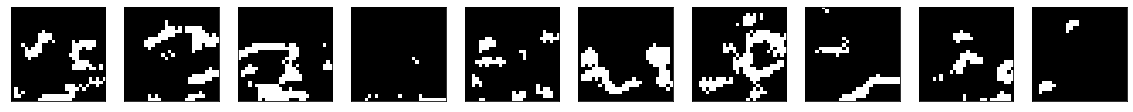

In [7]:
# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.utils.save_img(
        f"{d}-generated_image-ep_{current_epoch}-{i}.png", deprocess_image(np.squeeze(pic, -1))
    )
    
# 생성된 샘플 display
plt.figure(figsize=(20,2))
for c in range(10):
    plt.subplot(1,10,c+1)
    plt.imshow(plt.imread(f"{d}-generated_image-ep_{current_epoch}-{c}.png"),cmap='gray')
    plt.xticks([]); plt.yticks([])

In [8]:
epoch = 9
pixel_cnn.fit(
    data_train, data_train, validation_data=(data_test, data_test), batch_size=128, epochs=epoch, verbose=2
)
current_epoch += epoch

Epoch 1/9
43/43 - 18s - loss: 0.1178 - val_loss: 0.1094 - 18s/epoch - 411ms/step
Epoch 2/9
43/43 - 18s - loss: 0.1075 - val_loss: 0.1050 - 18s/epoch - 411ms/step
Epoch 3/9
43/43 - 18s - loss: 0.1037 - val_loss: 0.1023 - 18s/epoch - 409ms/step
Epoch 4/9
43/43 - 18s - loss: 0.1016 - val_loss: 0.1009 - 18s/epoch - 411ms/step
Epoch 5/9
43/43 - 18s - loss: 0.1002 - val_loss: 0.0997 - 18s/epoch - 409ms/step
Epoch 6/9
43/43 - 17s - loss: 0.0983 - val_loss: 0.0985 - 17s/epoch - 406ms/step
Epoch 7/9
43/43 - 18s - loss: 0.0984 - val_loss: 0.0967 - 18s/epoch - 412ms/step
Epoch 8/9
43/43 - 18s - loss: 0.0965 - val_loss: 0.0958 - 18s/epoch - 413ms/step
Epoch 9/9
43/43 - 18s - loss: 0.0960 - val_loss: 0.0958 - 18s/epoch - 408ms/step


100%|██████████| 28/28 [00:58<00:00,  2.10s/it]


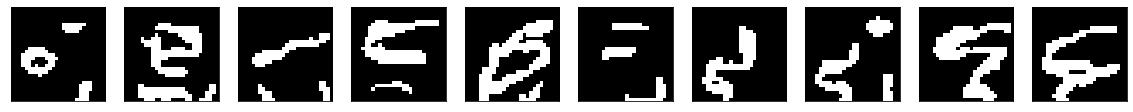

In [9]:
# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.utils.save_img(
        f"{d}-generated_image-ep_{current_epoch}-{i}.png", deprocess_image(np.squeeze(pic, -1))
    )
    
# 생성된 샘플 display
plt.figure(figsize=(20,2))
for c in range(10):
    plt.subplot(1,10,c+1)
    plt.imshow(plt.imread(f"{d}-generated_image-ep_{current_epoch}-{c}.png"),cmap='gray')
    plt.xticks([]); plt.yticks([])

In [10]:
epoch = 40
pixel_cnn.fit(
    data_train, data_train, validation_data=(data_test, data_test), batch_size=128, epochs=epoch, verbose=2
)
current_epoch += epoch

Epoch 1/40
43/43 - 18s - loss: 0.0951 - val_loss: 0.0955 - 18s/epoch - 409ms/step
Epoch 2/40
43/43 - 18s - loss: 0.0945 - val_loss: 0.0935 - 18s/epoch - 409ms/step
Epoch 3/40
43/43 - 18s - loss: 0.0943 - val_loss: 0.0933 - 18s/epoch - 408ms/step
Epoch 4/40
43/43 - 18s - loss: 0.0936 - val_loss: 0.0952 - 18s/epoch - 410ms/step
Epoch 5/40
43/43 - 18s - loss: 0.0931 - val_loss: 0.0931 - 18s/epoch - 412ms/step
Epoch 6/40
43/43 - 18s - loss: 0.0935 - val_loss: 0.0924 - 18s/epoch - 409ms/step
Epoch 7/40
43/43 - 18s - loss: 0.0933 - val_loss: 0.0924 - 18s/epoch - 408ms/step
Epoch 8/40
43/43 - 18s - loss: 0.0924 - val_loss: 0.0920 - 18s/epoch - 412ms/step
Epoch 9/40
43/43 - 18s - loss: 0.0924 - val_loss: 0.0931 - 18s/epoch - 409ms/step
Epoch 10/40
43/43 - 18s - loss: 0.0919 - val_loss: 0.0912 - 18s/epoch - 408ms/step
Epoch 11/40
43/43 - 18s - loss: 0.0915 - val_loss: 0.0912 - 18s/epoch - 408ms/step
Epoch 12/40
43/43 - 18s - loss: 0.0914 - val_loss: 0.0912 - 18s/epoch - 407ms/step
Epoch 13/40
4

100%|██████████| 28/28 [00:59<00:00,  2.11s/it]


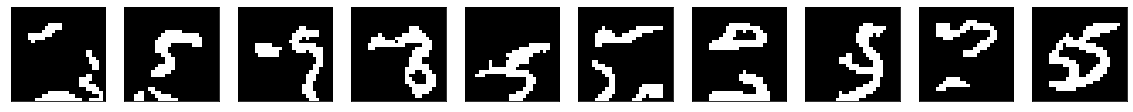

In [11]:
# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.utils.save_img(
        f"{d}-generated_image-ep_{current_epoch}-{i}.png", deprocess_image(np.squeeze(pic, -1))
    )
    
# 생성된 샘플 display
plt.figure(figsize=(20,2))
for c in range(10):
    plt.subplot(1,10,c+1)
    plt.imshow(plt.imread(f"{d}-generated_image-ep_{current_epoch}-{c}.png"),cmap='gray')
    plt.xticks([]); plt.yticks([])

In [12]:
epoch = 50
pixel_cnn.fit(
    data_train, data_train, validation_data=(data_test, data_test), batch_size=128, epochs=epoch, verbose=2
)
current_epoch += epoch

Epoch 1/50
43/43 - 18s - loss: 0.0873 - val_loss: 0.0896 - 18s/epoch - 409ms/step
Epoch 2/50
43/43 - 18s - loss: 0.0876 - val_loss: 0.0885 - 18s/epoch - 410ms/step
Epoch 3/50
43/43 - 18s - loss: 0.0871 - val_loss: 0.0886 - 18s/epoch - 411ms/step
Epoch 4/50
43/43 - 20s - loss: 0.0872 - val_loss: 0.0905 - 20s/epoch - 454ms/step
Epoch 5/50
43/43 - 22s - loss: 0.0874 - val_loss: 0.0891 - 22s/epoch - 510ms/step
Epoch 6/50
43/43 - 18s - loss: 0.0871 - val_loss: 0.0888 - 18s/epoch - 412ms/step
Epoch 7/50
43/43 - 18s - loss: 0.0873 - val_loss: 0.0897 - 18s/epoch - 414ms/step
Epoch 8/50
43/43 - 18s - loss: 0.0868 - val_loss: 0.0888 - 18s/epoch - 412ms/step
Epoch 9/50
43/43 - 18s - loss: 0.0870 - val_loss: 0.0888 - 18s/epoch - 411ms/step
Epoch 10/50
43/43 - 18s - loss: 0.0874 - val_loss: 0.0881 - 18s/epoch - 412ms/step
Epoch 11/50
43/43 - 20s - loss: 0.0866 - val_loss: 0.0879 - 20s/epoch - 455ms/step
Epoch 12/50
43/43 - 22s - loss: 0.0865 - val_loss: 0.0881 - 22s/epoch - 510ms/step
Epoch 13/50
4

100%|██████████| 28/28 [00:58<00:00,  2.09s/it]


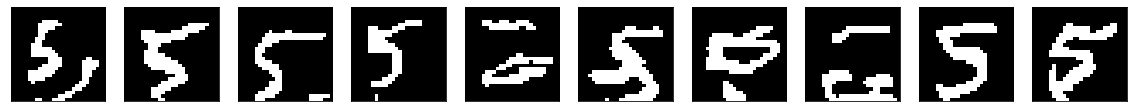

In [13]:
# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.utils.save_img(
        f"{d}-generated_image-ep_{current_epoch}-{i}.png", deprocess_image(np.squeeze(pic, -1))
    )
    
# 생성된 샘플 display
plt.figure(figsize=(20,2))
for c in range(10):
    plt.subplot(1,10,c+1)
    plt.imshow(plt.imread(f"{d}-generated_image-ep_{current_epoch}-{c}.png"),cmap='gray')
    plt.xticks([]); plt.yticks([])

In [14]:
epoch = 100
pixel_cnn.fit(
    data_train, data_train, validation_data=(data_test, data_test), batch_size=128, epochs=epoch, verbose=2
)
current_epoch += epoch
print('current_epoch: ', current_epoch)

Epoch 1/100
43/43 - 18s - loss: 0.0845 - val_loss: 0.0880 - 18s/epoch - 412ms/step
Epoch 2/100
43/43 - 18s - loss: 0.0841 - val_loss: 0.0882 - 18s/epoch - 411ms/step
Epoch 3/100
43/43 - 18s - loss: 0.0839 - val_loss: 0.0878 - 18s/epoch - 409ms/step
Epoch 4/100
43/43 - 18s - loss: 0.0839 - val_loss: 0.0894 - 18s/epoch - 414ms/step
Epoch 5/100
43/43 - 18s - loss: 0.0839 - val_loss: 0.0883 - 18s/epoch - 413ms/step
Epoch 6/100
43/43 - 18s - loss: 0.0838 - val_loss: 0.0881 - 18s/epoch - 410ms/step
Epoch 7/100
43/43 - 18s - loss: 0.0837 - val_loss: 0.0883 - 18s/epoch - 409ms/step
Epoch 8/100
43/43 - 18s - loss: 0.0840 - val_loss: 0.0887 - 18s/epoch - 412ms/step
Epoch 9/100
43/43 - 18s - loss: 0.0836 - val_loss: 0.0879 - 18s/epoch - 414ms/step
Epoch 10/100
43/43 - 18s - loss: 0.0837 - val_loss: 0.0880 - 18s/epoch - 411ms/step
Epoch 11/100
43/43 - 18s - loss: 0.0836 - val_loss: 0.0880 - 18s/epoch - 409ms/step
Epoch 12/100
43/43 - 18s - loss: 0.0834 - val_loss: 0.0883 - 18s/epoch - 410ms/step
E

100%|██████████| 28/28 [00:58<00:00,  2.09s/it]


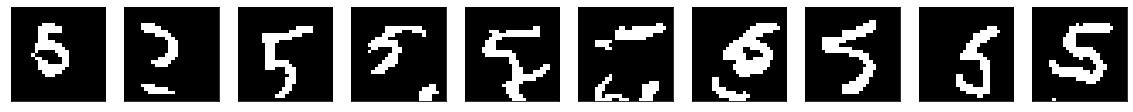

In [15]:
# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.utils.save_img(
        f"{d}-generated_image-ep_{current_epoch}-{i}.png", deprocess_image(np.squeeze(pic, -1))
    )
    
# 생성된 샘플 display
plt.figure(figsize=(20,2))
for c in range(10):
    plt.subplot(1,10,c+1)
    plt.imshow(plt.imread(f"{d}-generated_image-ep_{current_epoch}-{c}.png"),cmap='gray')
    plt.xticks([]); plt.yticks([])